In [1]:
from typing import List, Dict, Callable
import json, pydantic, os, dotenv, pandas, datetime, matplotlib.pyplot, seaborn
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
from langchain_openai import ChatOpenAI

dotenv.load_dotenv()

True

# Loading Truth

In [2]:
TRUTH = json.load(open("truth.json", encoding="utf-8"))
TRUTH

{"J'ai un problème de mdp": ['Les caractères spéciaux ne sont pas acceptés dans les mots de passe.',
  'Le mot de passe doit contenir au moins 8 caractères.'],
 'Je ne sais pas à quel réseau me connecter': ['Il faut se connecter à eduroam.',
  'Le réseau cacahuète est également disponible pour les invités.'],
 'Comment faire pour que mon poste téléphonique soit transféré vers un autre numéro ? Je suis sur le poste 4242 et je souhaite le transférer vers le poste 1337.': ['Pour transférer les appels, composez le 82 sur votre poste téléphonique.',
  'Ensuite, composez le numéro du poste destinataire du transfert (par exemple, « 82 1337 » si vous transférez vers le 1337).'],
 'Je suis sur le poste téléphonique 4242, les personnes arrivent à me joindre depuis des postes UTC, mais pas depuis l’extérieur, comment résoudre le problème ?': ["Le poste téléphonique 4242 n'est pas une ligne directe et ne fonctionne qu'en interne à l’UTC.",
  "Pour recevoir des appels de l'extérieur sur ce type de 

# Définition des fonctions d'inférence

In [3]:
from rag.keywords_inference import respond

respond("J'ai un problème de mot de passe")

'Pour vous aider efficacement, pourriez-vous préciser  :\n\n1. Lequel de vos mots de passe pose problème ?  \n   - votre compte UTC (portail comptes.utc.fr) ?  \n   - votre session Windows (PC de bureau/laptop) ?  \n   - un accès à une imprimante ou à un partage réseau ?  \n   - autre (messagerie, VPN, etc.) ?\n\n2. Quel est exactement le symptôme ?  \n   - « Mot de passe oublié » (erreur d’authentification)  \n   - Explosions d’erreurs après le changement  \n   - Blocage de compte, message « compte verrouillé »  \n\nEn attendant votre précision, voilà quelques procédures génériques :\n\nA. Si c’est votre compte UTC (portail comptes.utc.fr)  \n– Allez sur : https://comptes.utc.fr/accounts-web/tools/changePassword.xhtml  \n– Identifiez-vous ou cliquez « Mot de passe oublié »  \n– Suivez la procédure de réinitialisation  \n  \nB. Si c’est votre session Windows (PC professionnel UTC ou personnel)  \n– Appuyez simultanément sur Ctrl + Alt + Suppr  \n– Choisissez « Modifier un mot de passe 

# Evaluation des Requêtes

In [4]:
from rag.keywords_inference import respond

EVAL = pandas.DataFrame(
    {
        "delai": [],   # temps de réponse
        "rappel": [],  # proportion d'information retrouvée
        "volume": [],  # taille de la reponse
        "methode": []    # nom de la méthode
    }
)

methods: Dict[str, Callable[[str], str]] = {
    "keyword": respond,
}

for sentence, knowledge in TRUTH.items():
    
    for method_name, method in methods.items():
        
        print(f"Testing [{method_name}] on \"{sentence}\"")
        
        start_time = datetime.datetime.now()
        response = method(sentence)
        delay = (datetime.datetime.now() - start_time).total_seconds()
        
        # Test du rappel
        class Analysis(pydantic.BaseModel):
            knowledge_item_in_document_count: int = pydantic.Field(
                default=0,
                description="Nombre d'éléments de la liste de connaissances exprimés dans le document"
            )
        analysis: Analysis = ChatOpenAI(
            api_key=os.getenv("OPENAI_API_KEY"),
            model="gpt-4.1-mini"
        ).with_structured_output(Analysis).invoke(
            [
                SystemMessage(
                    content="Count the number of unique items from the knowledge list that are mentioned in the ai response."
                            + "It does not matter if the item is mentioned in the same sentence or not. "
                            + "Nor if the item is mentioned in the same form or not. "
                            + "What matters is that the meaning and all meaningful elements from an item are present for it to be counted in."
                            + "\n\nKnowledge list: "
                            + str(knowledge)
                            + "\n\nAI Response: \n"
                            + response
                ),
            ]
        )
        
        EVAL = pandas.concat(
            [
                EVAL,
                pandas.DataFrame(
                    {
                        "delai": [delay],
                        "rappel": [analysis.knowledge_item_in_document_count / len(knowledge)],
                        "volume": [len(response)],
                        "methode": [method_name]
                    }
                )
            ],
            ignore_index=True
        )
        
EVAL

Testing [keyword] on "J'ai un problème de mdp"
Testing [keyword] on "Je ne sais pas à quel réseau me connecter"
Testing [keyword] on "Comment faire pour que mon poste téléphonique soit transféré vers un autre numéro ? Je suis sur le poste 4242 et je souhaite le transférer vers le poste 1337."
Testing [keyword] on "Je suis sur le poste téléphonique 4242, les personnes arrivent à me joindre depuis des postes UTC, mais pas depuis l’extérieur, comment résoudre le problème ?"
Testing [keyword] on "Je suis sur le poste téléphonique 4532, j’arrive à joindre les autres personnes avec des numéros de postes extérieurs, mais pas les personnes hors UTC (numéro de portable par exemple)"
Testing [keyword] on "A chaque fois que j’essai d’ouvrir une page web, j’ai « erreur SSL »"
Testing [keyword] on "Comment configurer mes mails avec thunderbird ?"
Testing [keyword] on "Je n’arrive pas à me connecter à eduroam, mais ca marche pour les autres réseaux."
Testing [keyword] on "J’arrive à me connecter à i

,delai,rappel,volume,methode
0,12.917138,0.50,1110.0,keyword
1,11.958610,0.50,2117.0,keyword
2,11.458449,1.00,713.0,keyword
3,16.292621,0.25,996.0,keyword
4,12.082330,0.50,1114.0,keyword
5,13.036604,1.00,2593.0,keyword
6,10.537546,1.00,1826.0,keyword
7,11.746099,1.00,2196.0,keyword
8,15.300192,1.00,1843.0,keyword
9,13.777745,1.00,2394.0,keyword


Text(0.5, 1.0, 'Volume de la réponse')

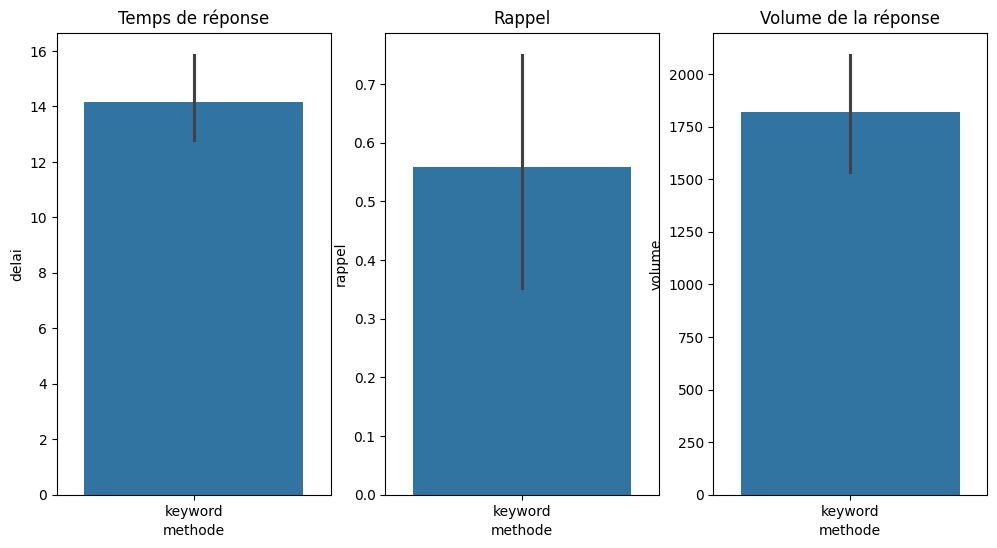

In [5]:
plt, axs = matplotlib.pyplot.subplots(1, 3, figsize=(12, 6))

# plot delai, rappel and volume
seaborn.barplot(data=EVAL, x="methode", y="delai", ax=axs[0])
axs[0].set_title("Temps de réponse")
seaborn.barplot(data=EVAL, x="methode", y="rappel", ax=axs[1])
axs[1].set_title("Rappel")
seaborn.barplot(data=EVAL, x="methode", y="volume", ax=axs[2])
axs[2].set_title("Volume de la réponse")